In [1]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

# Load data

In [2]:
df_train = pd.read_csv("data/ADNIMERGE_train.csv")
df_test = pd.read_csv("data/ADNIMERGE_test.csv")

In [3]:
X_train = df_train.drop(['RID', 'DX_bl'], axis=1).copy()
y_train = df_train['DX_bl'].copy()
X_test = df_test.drop(['RID', 'DX_bl'], axis=1).copy()
y_test = df_test['DX_bl'].copy()

# Significance of Predictors

We would like to find out the most significant variables in the model. These variables have the strongest predicting power, and are thus the most useful in the diagnosis of Alzheimer's disease. Identifying these variables can eliminate the number of tests a patient has to go through to get an accurate diagnosis. 

For logistic regression with l1 regularization, we used bootstraping (200 iterations) to find the most significant predictors. For random forest, we chcked the returned attribute `feature_importances_`.

## Bootstrap

In [4]:
log_l1 = LogisticRegressionCV(penalty = 'l1', solver = 'liblinear',random_state=9001)
log_l1.fit(X_train,y_train)
c = log_l1.C_[0]

iterations = 200
boot = np.zeros((X_train.shape[1], iterations))
for i in range(iterations):
    np.random.seed(2*i)
    boot_rows = np.random.choice(range(X_train.shape[0]),
                                 size=X_train.shape[0], replace=True)
    X_train_boot = X_train.values[boot_rows]
    y_train_boot = y_train.values[boot_rows]
    model_boot = LogisticRegression(penalty = 'l1', C=c)
    model_boot.fit(X_train_boot, y_train_boot)
    boot[:,i] = model_boot.coef_[2,:]
    
boot_ci_upper = np.percentile(boot, 95, axis=1)
boot_ci_lower = np.percentile(boot, 5, axis=1)
sig_b_ct = []
for i in range(X_train.shape[1]):
    if boot_ci_upper[i]<0 or boot_ci_lower[i]>0:
        sig_b_ct.append(i)
        
print("Most significant coefficients: ",len(sig_b_ct))
print(X_train.columns[sig_b_ct])

Most significant coefficients:  5
Index(['ADAS13', 'MMSE', 'RAVLT_immediate', 'FAQ', 'ICV_slope'], dtype='object')


Surprisingly, we only have 5 significant predictors using bootstrap method and four of them are cognitive assessments which don't cost as much as brain imaing tests. Specifically, the significant assessments are: 
- **`ADAS13`**: Alzheimer’s Disease Assessment Scale
- **`MMSE`**: Mini-Mental State Examination
- **`RAVLT_immediate`**: Rey Auditory Verbal Learning Immediate Test
- **`FAQ`**: Functional Activities Questionnaire in Older Adults with Dementia. 
We found this result a bit doubtful because no brain imaging tests are picked as significant predictors while studies have shown the great important role of brain imaging in diagnosing Alzheimer's Disease. However, if other models also give similar result, patients are likely to save a lot of money and time. 
- **`ICV_slope`**: The change of intracranial vault volume in magnetic resonance imaging(MRI) result

## Feature importance by Random Forest

In [5]:
rf_best = RandomForestClassifier(n_estimators=32, max_depth=12,random_state=9001)
rf_best.fit(X_train, y_train)
imp_features = np.array(X_train.columns)[rf_best.feature_importances_!=0]
print("The most important {} features:".format(len(imp_features)))
print(imp_features)

The most important 73 features:
['PTAGE' 'PTGENDER' 'PTEDUCAT' 'PTRACCAT_Asian' 'PTRACCAT_Black'
 'PTRACCAT_More_than_one' 'PTRACCAT_White' 'PTETHCAT_Not_Hisp/Latino'
 'PTMARRY_Married' 'PTMARRY_Never_married' 'PTMARRY_Widowed' 'APOE4'
 'CSF_ABETA' 'CSF_TAU' 'CSF_PTAU' 'FDG' 'FDG_slope' 'AV45' 'AV45_slope'
 'ADAS13' 'ADAS13_slope' 'MMSE' 'MMSE_slope' 'RAVLT_immediate'
 'RAVLT_immediate_slope' 'RAVLT_learning' 'RAVLT_learning_slope'
 'RAVLT_forgetting' 'RAVLT_forgetting_slope' 'RAVLT_perc_forgetting'
 'RAVLT_perc_forgetting_slope' 'MOCA' 'MOCA_slope' 'EcogPtMem'
 'EcogPtMem_slope' 'EcogPtLang' 'EcogPtLang_slope' 'EcogPtVisspat'
 'EcogPtVisspat_slope' 'EcogPtPlan' 'EcogPtPlan_slope' 'EcogPtOrgan'
 'EcogPtOrgan_slope' 'EcogPtDivatt' 'EcogPtDivatt_slope' 'EcogSPMem'
 'EcogSPMem_slope' 'EcogSPLang' 'EcogSPLang_slope' 'EcogSPVisspat'
 'EcogSPVisspat_slope' 'EcogSPPlan' 'EcogSPPlan_slope' 'EcogSPOrgan'
 'EcogSPOrgan_slope' 'EcogSPDivatt' 'EcogSPDivatt_slope' 'FAQ' 'FAQ_slope'
 'Ventricles' 'V

In [20]:
list(set(X_train.columns) - set(imp_features))

['PTRACCAT_Unknown', 'PTRACCAT_Hawaiian/Other_PI']

### Significance ranking of predictors

In [6]:
imp = rf_best.feature_importances_
ranks_rf = np.searchsorted(np.sort(imp), imp)
ranks_rf=len(ranks_rf)-ranks_rf
ranks_rf

array([14, 65, 61, 67, 71, 75, 69, 75, 68, 73, 64, 72, 70, 66, 28, 11, 58,
       16, 23, 15, 52,  3, 30,  1, 10, 12, 41, 56, 38, 62, 47,  8, 48,  7,
       22,  4, 46,  6, 45, 59, 44, 63, 57, 60, 54, 43, 37,  2, 27, 19, 18,
       51, 25, 26, 32, 20, 49,  9, 39,  5, 13, 31, 21, 24, 42, 29, 36, 17,
       50, 34, 35, 55, 40, 33, 53])

In [7]:
ranked_x_rf = [None]*len(X_train.columns)
for i, rank in enumerate(ranks_rf):
    ranked_x_rf[rank-1] = X_train.columns[i]
print('Ranked Predictors by Random Forest Feature Importance:\n')
print(ranked_x_rf)

Ranked Predictors by Random Forest Feature Importance:

['MMSE', 'EcogSPMem', 'ADAS13', 'EcogPtMem', 'FAQ', 'EcogPtLang', 'MOCA', 'RAVLT_perc_forgetting', 'EcogSPDivatt', 'MMSE_slope', 'CSF_TAU', 'RAVLT_immediate', 'FAQ_slope', 'PTAGE', 'AV45', 'FDG', 'Entorhinal', 'EcogSPLang_slope', 'EcogSPLang', 'EcogSPOrgan', 'Ventricles_slope', 'MOCA_slope', 'FDG_slope', 'Hippocampus', 'EcogSPVisspat_slope', 'EcogSPPlan', 'EcogSPMem_slope', 'CSF_ABETA', 'WholeBrain', 'ADAS13_slope', 'Ventricles', 'EcogSPPlan_slope', 'ICV', 'Fusiform', 'Fusiform_slope', 'WholeBrain_slope', 'EcogPtDivatt_slope', 'RAVLT_learning_slope', 'EcogSPDivatt_slope', 'MidTemp_slope', 'RAVLT_immediate_slope', 'Hippocampus_slope', 'EcogPtDivatt', 'EcogPtVisspat_slope', 'EcogPtLang_slope', 'EcogPtMem_slope', 'RAVLT_forgetting_slope', 'RAVLT_perc_forgetting_slope', 'EcogSPOrgan_slope', 'Entorhinal_slope', 'EcogSPVisspat', 'AV45_slope', 'ICV_slope', 'EcogPtOrgan_slope', 'MidTemp', 'RAVLT_learning', 'EcogPtPlan_slope', 'CSF_PTAU', 

Using random forest classifier, we ended up with 73 important features. 
Only `PTRACCAT_Hawaiian/Other_PI`, `PTRACCAT_Unknown` are not significant, all of which are indicators of race and marriage. Notably, among the top ranking 15 ranked predictors, `MMSE`, `FAQ`, `ADAS13`, and `RAVLT_immediate` appear again (also appeared in bootstraping result), which adds even more significance to these cognition tests. Additionally, many Every Cognition Test(ECogxxx) results are also shown to be significant here. We will see how they perfrom in the following selections.

## Forward and Backward Selection

In [8]:
def step_forwards_backwards(direction='forward'):
    

    
    assert direction in ['forward', 'backward']

    predictors = set(X_train.columns)
    predictors_ls = list(X_train.columns)
    selected_predictors = set() if direction=='forward' else set(predictors)
    
    n = X_train.shape[0]
    best_acc = np.inf
    
    best_accuracy = []
    best_models = []
    
    rank = 0
    
    if direction == 'forward':
        ranks = [len(predictors_ls)-1]*len(predictors_ls)
        X = X_train[list(selected_predictors)].values
        while (True):
            
            possible_scores = []
            possible_predictors = list(selected_predictors ^ predictors)
            
            if len(possible_predictors) == 0:
                break
                
            cv_fold = KFold(n_splits=3, shuffle=True, random_state=9001)
            for predictor in possible_predictors:
                x_temp = np.concatenate([X, X_train[predictor].values.reshape(-1,1)], axis=1)
                rf = RandomForestClassifier(n_estimators=32, max_depth=12,random_state=9001)
                scores = np.mean(cross_val_score(rf, x_temp, y_train, cv=cv_fold))
                possible_scores.append(scores)
                
            best_predictor_ix = np.argmax(possible_scores)
            best_predictor = possible_predictors[best_predictor_ix]
            ranks[predictors_ls.index(best_predictor)]=rank
            
            best_acc = np.max(possible_scores)
            best_accuracy.append(best_acc)
            
            selected_predictors.add(best_predictor)            
            X = np.concatenate([X, X_train[best_predictor].values.reshape(-1,1)], axis=1)
            best_models.append(list(selected_predictors))
            
            rank += 1

    else:
        ranks = [0]*len(predictors_ls)
        while (True):
            possible_scores = []
            possible_predictors = list(selected_predictors)

            if len(possible_predictors) == 0:
                break
            cv_fold = KFold(n_splits=3, shuffle=True, random_state=9001)              
            for predictor in possible_predictors:
    
                X = np.concatenate([np.ones(n).reshape(-1,1), 
                                    X_train[list(selected_predictors - set([predictor]))].values], 
                                   axis=1)
                if(X.shape[1] != 0):
                    rf = RandomForestClassifier(n_estimators=32, max_depth=12,random_state=9001)
                    scores = np.mean(cross_val_score(rf, X, y_train, cv=cv_fold))
                    possible_scores.append(scores)

            best_predictor_ix = np.argmax(possible_scores)
            best_predictor = possible_predictors[best_predictor_ix] 
            ranks[predictors_ls.index(best_predictor)]=len(predictors_ls)-rank-1

            best_acc = possible_scores[best_predictor_ix]
            selected_predictors.discard(best_predictor)
            
            best_accuracy.append(best_acc)
            best_models.append(list(selected_predictors))
            
            rank += 1
            
    index_of_best_accuracy = np.argmax(best_accuracy)

    return (best_models[index_of_best_accuracy],ranks)

In [9]:
predictors_forward,ranks_f = step_forwards_backwards(direction='forward')
predictors_backward,ranks_b = step_forwards_backwards(direction='backward')

### Significance ranking of predictors by stepwise selections

In [10]:
print("Predictors selected by forward selection (", 
      len(predictors_forward), " predictors): \n", predictors_forward,'\n',ranks_f)
print("\n-----------------------------------------\n")
print("Predictors selected by backward selection: (", 
      len(predictors_backward), " predictors): \n", predictors_backward,'\n',ranks_b)

Predictors selected by forward selection ( 15  predictors): 
 ['PTAGE', 'AV45_slope', 'PTMARRY_Never_married', 'WholeBrain_slope', 'ADAS13', 'Fusiform_slope', 'PTETHCAT_Not_Hisp/Latino', 'PTRACCAT_Unknown', 'FAQ', 'EcogPtMem', 'FDG_slope', 'MMSE', 'CSF_TAU', 'PTRACCAT_Hawaiian/Other_PI', 'EcogSPMem'] 
 [6, 67, 71, 34, 56, 7, 24, 8, 19, 10, 25, 14, 63, 61, 69, 3, 49, 29, 13, 72, 11, 0, 53, 5, 58, 48, 21, 46, 44, 16, 66, 54, 64, 40, 41, 4, 35, 45, 27, 62, 31, 60, 17, 32, 52, 59, 38, 2, 20, 36, 43, 55, 22, 23, 47, 42, 33, 74, 39, 12, 26, 51, 28, 70, 65, 50, 1, 73, 15, 57, 9, 37, 68, 30, 18]

-----------------------------------------

Predictors selected by backward selection: ( 13  predictors): 
 ['PTAGE', 'MMSE', 'PTMARRY_Married', 'ICV_slope', 'EcogPtLang', 'PTGENDER', 'EcogSPLang_slope', 'MidTemp_slope', 'FDG_slope', 'ICV', 'EcogSPPlan', 'PTRACCAT_Hawaiian/Other_PI', 'RAVLT_perc_forgetting_slope'] 
 [9, 7, 43, 39, 63, 11, 68, 70, 22, 65, 6, 71, 64, 19, 30, 13, 53, 32, 3, 36, 47, 72, 62

In [11]:
ranked_x_forward = [None]*len(X_train.columns)
for i, rank in enumerate(ranks_f):
    ranked_x_forward[rank] = X_train.columns[i]
print('Ranked Predictors by Forward Selection:\n')
print(ranked_x_forward)

Ranked Predictors by Forward Selection:

['ADAS13', 'WholeBrain_slope', 'EcogSPMem', 'CSF_TAU', 'EcogPtMem', 'MMSE', 'PTAGE', 'PTRACCAT_Hawaiian/Other_PI', 'PTRACCAT_Unknown', 'Fusiform_slope', 'PTETHCAT_Not_Hisp/Latino', 'AV45_slope', 'FAQ', 'FDG_slope', 'PTMARRY_Never_married', 'Entorhinal_slope', 'RAVLT_forgetting', 'EcogPtPlan_slope', 'ICV_slope', 'PTRACCAT_White', 'EcogSPMem_slope', 'RAVLT_immediate_slope', 'EcogSPVisspat_slope', 'EcogSPPlan', 'PTRACCAT_More_than_one', 'PTMARRY_Married', 'FAQ_slope', 'EcogPtLang_slope', 'Ventricles_slope', 'FDG', 'ICV', 'EcogPtVisspat_slope', 'EcogPtOrgan', 'EcogSPOrgan_slope', 'PTRACCAT_Asian', 'EcogPtMem_slope', 'EcogSPLang', 'MidTemp', 'EcogPtDivatt_slope', 'EcogSPDivatt_slope', 'MOCA', 'MOCA_slope', 'EcogSPOrgan', 'EcogSPLang_slope', 'RAVLT_learning_slope', 'EcogPtLang', 'RAVLT_learning', 'EcogSPPlan_slope', 'RAVLT_immediate', 'CSF_PTAU', 'WholeBrain', 'Ventricles', 'EcogPtOrgan_slope', 'ADAS13_slope', 'RAVLT_perc_forgetting', 'EcogSPVisspat',

In [12]:
ranked_x_backward = [None]*len(X_train.columns)
for i, rank in enumerate(ranks_b):
    ranked_x_backward[rank] = X_train.columns[i]
print('Ranked Predictors by Backward Selection:\n')
print(ranked_x_backward)

Ranked Predictors by Backward Selection:

['MMSE', 'EcogSPPlan', 'EcogPtLang', 'FDG_slope', 'MidTemp_slope', 'RAVLT_perc_forgetting_slope', 'PTMARRY_Married', 'PTGENDER', 'EcogSPLang_slope', 'PTAGE', 'ICV_slope', 'PTRACCAT_Hawaiian/Other_PI', 'ICV', 'CSF_TAU', 'EcogPtVisspat_slope', 'EcogSPDivatt_slope', 'Entorhinal_slope', 'EcogSPDivatt', 'Fusiform', 'APOE4', 'EcogSPMem_slope', 'EcogPtDivatt', 'PTRACCAT_White', 'Fusiform_slope', 'MMSE_slope', 'RAVLT_perc_forgetting', 'EcogPtOrgan_slope', 'MOCA', 'EcogPtMem_slope', 'RAVLT_learning', 'CSF_ABETA', 'EcogPtVisspat', 'FDG', 'Hippocampus', 'RAVLT_learning_slope', 'EcogPtOrgan', 'AV45', 'RAVLT_immediate_slope', 'WholeBrain_slope', 'PTRACCAT_Asian', 'WholeBrain', 'EcogPtLang_slope', 'Ventricles', 'PTEDUCAT', 'EcogSPLang', 'FAQ_slope', 'MOCA_slope', 'AV45_slope', 'EcogSPOrgan_slope', 'EcogPtPlan_slope', 'RAVLT_forgetting', 'EcogSPPlan_slope', 'RAVLT_forgetting_slope', 'CSF_PTAU', 'RAVLT_immediate', 'EcogPtDivatt_slope', 'MidTemp', 'EcogPtMem', 

Backward selection chose much more predictors than forward selection.



### Combined significant predictors selected by RF, Forward and Backward selection

In [22]:
forward = set(predictors_forward)
backward = set(predictors_backward)
inter_f_b = forward.union(backward)
print('Combined significant predictors by forward and backward selection:\n')
print(inter_f_b)

Combined significant predictors by forward and backward selection:

{'PTAGE', 'PTMARRY_Married', 'EcogPtLang', 'PTMARRY_Never_married', 'MidTemp_slope', 'EcogSPPlan', 'WholeBrain_slope', 'ADAS13', 'Fusiform_slope', 'PTETHCAT_Not_Hisp/Latino', 'ICV_slope', 'FAQ', 'EcogPtMem', 'FDG_slope', 'MMSE', 'PTRACCAT_Unknown', 'PTRACCAT_Hawaiian/Other_PI', 'AV45_slope', 'PTGENDER', 'EcogSPLang_slope', 'ICV', 'CSF_TAU', 'RAVLT_perc_forgetting_slope', 'EcogSPMem'}


## Rank-Rank plot 

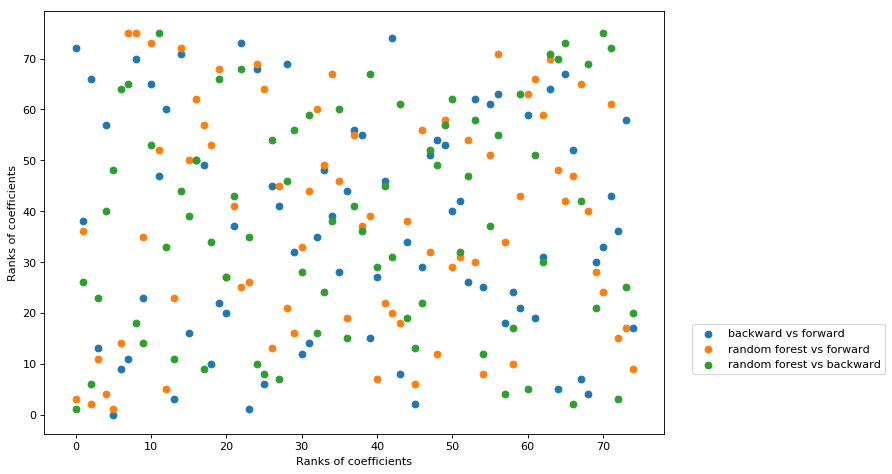

In [14]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression


fig=plt.figure(figsize=(10, 7), dpi= 80, facecolor='w', edgecolor='k')
#ax1 = fig.add_subplot(111)
plt.scatter(ranks_f,ranks_b,label='backward vs forward')
plt.scatter(ranks_f,ranks_rf,label='random forest vs forward')
plt.scatter(ranks_b,ranks_rf,label='random forest vs backward')


#plt.plot(ranks_f,ranks_b,label='backward vs forward',alpha=0.2)
#plt.plot(ranks_f,ranks_rf,label='random forest vs forward',alpha=0.2)
#plt.plot(ranks_b,ranks_rf,label='random forest vs backward',alpha=0.2)

plt.legend(loc='center', bbox_to_anchor=(1.2, 0.2), ncol=1)
plt.xlabel('Ranks of coefficients')
plt.ylabel('Ranks of coefficients')
plt.show()

## Model Testing on the selected variables

In [15]:
X_train_best1 = X_train[list(inter_f_b)]
X_test_best1 = X_test[list(inter_f_b)]
X_train_best2 = X_train[list(X_train.columns[sig_b_ct])]
X_test_best2 = X_test[list(X_train.columns[sig_b_ct])]
from sklearn.model_selection import GridSearchCV
cv_fold = KFold(n_splits=5, shuffle=True, random_state=9001)

In [16]:
# function to help compare the accuracy of models
def score(model, X_train, y_train, X_test, y_test):
    train_acc = model.score(X_train,y_train)
    test_acc = model.score(X_test,y_test)
    test_class0 = model.score(X_test[y_test==0], y_test[y_test==0])
    test_class1 = model.score(X_test[y_test==1], y_test[y_test==1])
    test_class2 = model.score(X_test[y_test==2], y_test[y_test==2])
    return pd.Series([train_acc, test_acc, test_class0, test_class1, test_class2],
                    index = ['Train accuracy', 'Test accuracy', 
                             "Test accuracy CN", "Test accuracy CI", "Test accuracy AD"])

### Logistic Regression Model 
with common predictors from RF, Forward, and Backward selection

In [17]:
model_ = LogisticRegression(penalty = 'l1', C=c)
model_.fit(X_train_best2, y_train)
model_.score(X_test_best2,y_test)
score(model_, X_train_best2, y_train, X_test_best2, y_test)

Train accuracy      0.710145
Test accuracy       0.691358
Test accuracy CN    0.023810
Test accuracy CI    0.935484
Test accuracy AD    0.888889
dtype: float64

### Random Forest Classifier
with common predictors from RF, Forward, and Backward selection

In [18]:
trees = [2**x for x in range(8)]  # 1, 2, 4, 8, 16, 32, ...
depth = [2, 4, 6, 8, 10]
parameters = {'n_estimators': trees,
              'max_depth': depth}
rf = RandomForestClassifier(random_state=9001)
rf_cv = GridSearchCV(rf, parameters, cv=cv_fold)
rf_cv.fit(X_train_best1, y_train)
best_score = np.argmax(rf_cv.cv_results_['mean_test_score'])
result = rf_cv.cv_results_['params'][best_score]
opt_depth = result['max_depth']
opt_tree = result['n_estimators']
print("Optimal number of trees {}, tree depth: {}".format(opt_tree, opt_depth))
rf = RandomForestClassifier(n_estimators=opt_tree, max_depth=opt_depth, random_state=9001)
rf.fit(X_train_best1, y_train)
print('\n')
print('Random Forest Training Accuracy: ', rf.score(X_train_best1,y_train))
print('Random Forest Test Accuracy: ', rf.score(X_test_best1,y_test))
rf_score = score(rf, X_train_best1, y_train, X_test_best1, y_test)
rf_score

Optimal number of trees 32, tree depth: 10


Random Forest Training Accuracy:  0.995169082126
Random Forest Test Accuracy:  0.753086419753


Train accuracy      0.995169
Test accuracy       0.753086
Test accuracy CN    0.476190
Test accuracy CI    0.860215
Test accuracy AD    0.814815
dtype: float64

Since the test results of the selected variables from only bootstraping didn't perform as well as the random forest classifier with common selected variables, we choose to rely on the significant predictors selected by the random forest classifier. Let's interpret the selected predictors:

- The tests completed excluded are: `FDG`, and `MOCA`, which means the results of those tests are not significant in the diagnosis, possibly because other assessments are testing similar aspects of the patients.

- The factors that are significant themselves but insignificant in their slopes are:`MMSE`, `EcogSPMem`, `ADAS13`,`EcogPtMem`,`CSF_TAU`,`FAQ`,`EcogPtLang`, and `EcogSPPlan`, which indicates that tests associated with these factors only need to be conducted once at baseline visit and are not necessary in the following visits. Specifically, Mini-Mental State Examination(`MMSE`), Everyday Cognition test on Participant Memory and Language, Study Partner Memory and Plan(`EcogSPMem`, `EcogPtMem`,`EcogPtLang`,`EcogSPPlan`), Functional Activities Questionnaire in Older Adults with Dementia(`FAQ`), Alzheimer’s Disease Assessment Scale(`ADAS13`) and biosample test(`CSF_TAU`) only need to be checked at the first visit.

- The factors that are significant in their slopes are: `AV45_slope`,
,`EcogSPLang_slope`, `EcogPtLang_slope`, `WholeBrain_slope`, `MidTemp_slope`, `Fusiform_slope`, `FDG_slope`,`RAVLT_perc_forgetting_slope` and `ICV_slope`, which means the change in these parameters within two years after the first visit is quite important for the diagnosis. So testing these parameters on each subsequent visit is necessary. Specifically, The tests that need to be conducted in every visit are **Ecog** (Everyday Cognition)test,**AV45** test, **FDG** imaging test, **RAVLT_learning** test and **MRI** test.

- Other significant demographic factors are: `PTAGE`(age), `PTMARRY_Married`, `PTMARRY_Never_married`, `PTETHCAT_Not_Hisp/Latino`, `PTRACCAT_Unknown`, and `PTRACCAT_Hawaiian/Other_PI`. 


Remarkably, `MMSE` appears in the all the variable selection procedures above. So we can conclude that it's a very essetial test in diagnosis of AD.